## Yahoo Fundamental

## STOCKS



In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import talib
import math
from datetime import datetime, timedelta
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
from bs4 import BeautifulSoup
import requests
from django.core.validators import RegexValidator
from django.http import JsonResponse, Http404
import pandas as pd
import matplotlib.pyplot as plt


In [2]:

# S&P 500 → ^GSPC
# Dow Jones → ^DJI
# Nasdaq 100 → ^NDX
# Russell 2000 → ^RUT
# DAX (Alemanha) → ^GDAXI
# Definir o ticker da ação
symbol = "GRAB"  # Apple Inc.
# symbol = "^GSPC"  # Apple Inc.
# symbol = "XLK"  # Apple Inc.

# Definir período e intervalo
period = "1y"       # Período de 1 mês
interval = "1d"      # Dados diários

In [3]:
yahoo_symbol_info = yf.Ticker(symbol).info
yahoo_symbol_balancesheet = yf.Ticker(symbol).balance_sheet
yahoo_symbol_balancesheet_quarter = yf.Ticker(symbol).quarterly_balance_sheet
yahoo_symbol_income = yf.Ticker(symbol).income_stmt
yahoo_symbol_income_quarter = yf.Ticker(symbol).quarterly_income_stmt
yahoo_symbol_cashflow = yf.Ticker(symbol).cash_flow
yahoo_symbol_cashflow_quarter = yf.Ticker(symbol).quarterly_cash_flow

In [4]:
# - Market Cap
market_cap = yahoo_symbol_info.get('marketCap')
if market_cap is None or (isinstance(market_cap, float) and math.isnan(market_cap)):
    market_cap = None

# - Total Debt
if 'Total Debt' in yahoo_symbol_balancesheet.index:
    total_debt = yahoo_symbol_balancesheet.loc["Total Debt"]
    if pd.isna(total_debt).all():
        total_debt = None
        total_debt_last = None
    else:
        total_debt = total_debt.dropna()
        total_debt_last = total_debt.iloc[0]
else:
    total_ebitda = None
    total_debt_last = None

# - Minority Interest
if 'Total Equity Gross Minority Interest' in yahoo_symbol_balancesheet.index:
    total_equity_gross_minority_interest = yahoo_symbol_balancesheet.loc["Total Equity Gross Minority Interest"]
    if pd.isna(total_equity_gross_minority_interest).all():
        total_equity_gross_minority_interest = None
        total_equity_gross_minority_interest_last = None
    else:
        total_equity_gross_minority_interest = total_equity_gross_minority_interest.dropna()
        total_equity_gross_minority_interest_last = total_equity_gross_minority_interest.iloc[0]
else:
    total_equity_gross_minority_interest = None
    total_equity_gross_minority_interest_last = None

# - Stockholders Equity
if 'Stockholders Equity' in yahoo_symbol_balancesheet.index:
    stockholders_equity = yahoo_symbol_balancesheet.loc["Stockholders Equity"]
    if pd.isna(stockholders_equity).all():
        stockholders_equity = None
        stockholders_equity_last = None
        stockholders_equity_mean = None
        last_stockholders_equity_mean = None
    else:
        stockholders_equity = stockholders_equity.dropna()
        stockholders_equity_last = stockholders_equity.iloc[0]
        stockholders_equity_mean = (stockholders_equity.shift(1) + stockholders_equity) / 2
        last_stockholders_equity_mean = stockholders_equity_mean.dropna().iloc[0]
else:
    stockholders_equity = None
    stockholders_equity_last = None
    stockholders_equity_mean = None
    last_stockholders_equity_mean = None

minority_interest = total_equity_gross_minority_interest_last - stockholders_equity_last \
    if stockholders_equity_last is not None \
    and total_equity_gross_minority_interest_last is not None \
    else None

preferred_equity = 0

# - Debt & cash (preferidos)
if 'Cash Cash Equivalents And Short Term Investments' in yahoo_symbol_balancesheet.index:
    cash_sti = yahoo_symbol_balancesheet.loc["Cash Cash Equivalents And Short Term Investments"]
    if pd.isna(cash_sti).all():
        cash_sti = None
        cash_sti_last = None
    else:
        cash_sti = cash_sti.dropna()
        cash_sti_last = cash_sti.iloc[0]
else:
    cash_sti = None
    cash_sti_last = None

if cash_sti_last is None:
    if 'Cash And Cash Equivalents' in yahoo_symbol_balancesheet.index:
        cash = yahoo_symbol_balancesheet.loc["Cash And Cash Equivalents"]
        if pd.isna(cash).all():
            cash = None
            cash_last = None
        else:
            cash = cash.dropna()
            cash_last = cash.iloc[0]
    else:
        cash = None
        cash_last = None

    if 'Other Short Term Investments' in yahoo_symbol_balancesheet.index:
        sti = yahoo_symbol_balancesheet.loc["Other Short Term Investments"]
        if pd.isna(cash).all():
            sti = None
            sti_last = None
        else:
            sti = sti.dropna()
            sti_last = sti.iloc[0]
    else:
        sti = None
        sti_last = None

    cash_sti_last = (cash_last or 0) + (sti_last or 0) \
        if cash_last is not None \
        and sti_last is not None \
        else None

enterprise_value = market_cap + total_debt_last + minority_interest + preferred_equity - cash_sti_last \
    if market_cap is not None \
    and total_debt_last is not None \
    and minority_interest is not None \
    and preferred_equity is not None \
    and cash_sti_last is not None \
    else None


# - Net Debt / EBITDA
net_debt = total_debt_last - cash_sti_last \
    if cash_sti_last is not None \
    and total_debt_last is not None \
    else None

# - Total Revenue ---- ADICIONAR ISTO em todo o lado e criar função generica
if 'EBITDA' in yahoo_symbol_income_quarter.index:
    total_ebitda = yahoo_symbol_income_quarter.loc['EBITDA']
    if pd.isna(total_ebitda).all():
        total_ebitda = None
        ebitda_ttm = None
    else:
        total_ebitda = total_ebitda.dropna()
        ebitda_ttm = total_ebitda.sum()
else:
    total_ebitda = None
    ebitda_ttm = None

net_debt_ebitda = net_debt / ebitda_ttm \
    if net_debt is not None \
    and ebitda_ttm is not None \
    and ebitda_ttm > 0 \
    else None

# - Interest Coverage (EBIT)
if 'EBIT' in yahoo_symbol_income_quarter.index:
    ebit_quarter = yahoo_symbol_income_quarter.loc['EBIT']
    if pd.isna(ebit_quarter).all():
        ebit_quarter = None
        ebit_quarter_ttm = None
    else:
        ebit_quarter = ebit_quarter.dropna()
        ebit_quarter_ttm = ebit_quarter.sum()
else:
    ebit_quarter = None
    ebit_quarter_ttm = None

# - Interest Expense
if 'Interest Expense' in yahoo_symbol_income.index:
    interest_expense = yahoo_symbol_income.loc['Interest Expense']
    if pd.isna(interest_expense).all():
        interest_expense = None
        interest_expense_ttm = None
        interest_expense_last = None
    else:
        interest_expense = interest_expense.dropna()
        interest_expense_ttm = interest_expense.sum()
        interest_expense_last = interest_expense.iloc[0]
else:
    interest_expense = None
    interest_expense_ttm = None
    interest_expense_last = None

interest_coverage_ebit = ebit_quarter_ttm / abs(interest_expense_ttm) \
    if ebit_quarter_ttm is not None \
    and interest_expense_ttm not in (None, 0) \
    else None

# - Current Racio
# current_assets
if 'Current Assets' in yahoo_symbol_balancesheet_quarter.index:
    current_assets_quarter = yahoo_symbol_balancesheet_quarter.loc['Current Assets']
    if pd.isna(current_assets_quarter).all():
        current_assets_quarter = None
        current_assets_quarter_last = None
    else:
        current_assets_quarter = current_assets_quarter.dropna()
        current_assets_quarter_last = current_assets_quarter.iloc[0]
else:
    current_assets_quarter = None
    current_assets_quarter_last = None

# current_liabilities
if 'Current Liabilities' in yahoo_symbol_balancesheet_quarter.index:
    current_liabilities_quarter = yahoo_symbol_balancesheet_quarter.loc['Current Liabilities']
    if pd.isna(current_liabilities_quarter).all():
        current_liabilities_quarter = None
        current_liabilities_quarter_last = None
    else:
        current_liabilities_quarter = current_liabilities_quarter.dropna()
        current_liabilities_quarter_last = current_liabilities_quarter.iloc[0]
else:
    current_liabilities_quarter = None
    current_liabilities_quarter_last = None

current_ratio = (current_assets_quarter_last / current_liabilities_quarter_last) \
    if current_liabilities_quarter_last not in (None, 0) \
    and current_assets_quarter_last is not None \
    else None

# inventory
if 'Inventory' in yahoo_symbol_balancesheet_quarter.index:
    inventory_quarter = yahoo_symbol_balancesheet_quarter.loc['Inventory']
    if pd.isna(inventory_quarter).all():
        inventory_quarter = None
        inventory_quarter_last = None
    else:
        inventory_quarter = inventory_quarter.dropna()
        inventory_quarter_last = inventory_quarter.iloc[0]
else:
    inventory_quarter = None
    inventory_quarter_last = None

quick_ratio = ((current_assets_quarter_last - inventory_quarter_last) / current_liabilities_quarter_last) \
    if current_assets_quarter_last is not None \
    and inventory_quarter_last is not None \
    and current_liabilities_quarter_last not in (None, 0) \
    else None



In [ ]:
company = yahoo_symbol_info.get("longName", "N/A")
sector = yahoo_symbol_info.get("sector", "N/A")
total_debt_last - cash_sti_last


print(r"Net Debt Ebida =" {net_debt_ebitda})

, interest_coverage_ebit, current_ratio, quick_ratio, net_debt, total_debt_last, cash_sti_last

('Grab Holdings Limited',
 'Technology',
 np.float64(-19.428044280442805),
 np.float64(0.041375872382851446),
 np.float64(1.8837955535182214),
 np.float64(1.8666055466422187),
 np.float64(-5265000000.0),
 np.float64(364000000.0),
 np.float64(5629000000.0))

Net Debt (Dívida Líquida) = Dívida total com custo – Caixa & equivalentes.
EBITDA = Lucro antes de juros, impostos, depreciação e amortização.

O rácio Net Debt / EBITDA mede quantos anos a empresa levaria para pagar a sua dívida líquida com o EBITDA gerado.

Se o resultado é negativo, significa que a empresa tem caixa líquido (ou seja, mais caixa do que dívida).
Quanto mais negativo, mais caixa sobrando.
Exemplo: –19,43 significa que o caixa líquido equivale a quase 19,5 vezes o EBITDA anual.
→ Isso é uma posição extremamente caixa-positiva.
Pode indicar:
empresa com muito caixa em relação ao tamanho das operações (talvez vendeu ativos, fez IPO, ou recebeu aporte);
ou EBITDA muito baixo/volátil, o que amplifica o rácio.


👉 Resumo prático:

Net Debt / EBITDA = –19,43 → empresa tem muito mais caixa que dívida. (ex.: resultado operacional quase nulo) ou porque a empresa recebeu dinheiro (venda de ativos, aumento de capital, IPO).

Interest Coverage = 0,04 → operacionalmente está a perder eficiência e não cobre juros com EBIT.

Leitura conjunta: a empresa não corre risco imediato de falência porque tem caixa líquido grande, mas a operação está fraca (não gera lucros suficientes para sustentar-se sem queimar caixa).

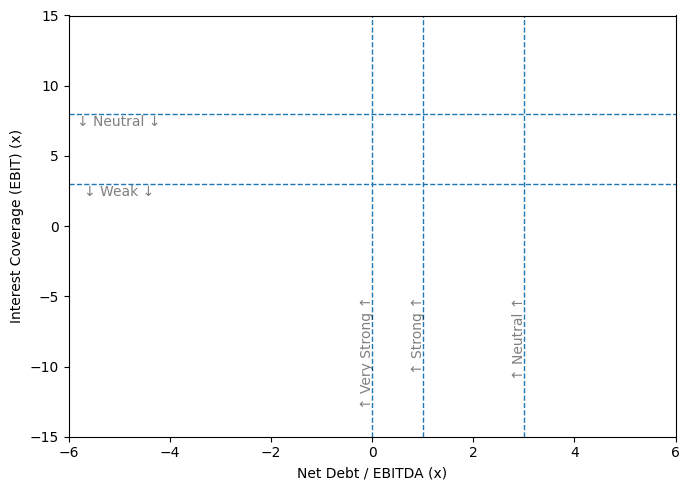

In [6]:
# Create the two requested charts using only matplotlib (no seaborn, no custom colors).
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# --- Input values provided by user ---
company = company
sector = sector
net_debt_ebitda = net_debt_ebitda          # N/A
interest_coverage_ebit = interest_coverage_ebit # Weak
current_ratio = current_ratio            # Good Debt Coverage
quick_ratio = quick_ratio              # Tight Margin to Debt

# Build a DataFrame so it's easy to extend with peers later
df = pd.DataFrame([{
    "company": company,
    "sector": sector,
    "net_debt_ebitda": net_debt_ebitda,
    "interest_coverage": interest_coverage_ebit, # interest_coverage_ebit,
    "current_ratio": current_ratio,
    "quick_ratio": quick_ratio
}])

# ---------------------------
# 1) Scatter: Net Debt/EBITDA vs Interest Coverage (EBIT)
# ---------------------------
fig1, ax1 = plt.subplots(figsize=(7, 5))

# Quadrant guide (typical comfort thresholds)
x_thr_1 = 3.0  # Net Debt/EBITDA Neutral
x_thr_2 = 1.0  # Net Debt/EBITDA Strong
x_thr_3 = 0.0  # Net Debt/EBITDA Very Strong

y_thr_1 = 3.0  # Interest coverage Weak
y_thr_2 = 8.0  # Interest coverage Neutral

ax1.axvline(x_thr_1, linestyle="--", linewidth=1, label='Neutral')
ax1.axvline(x_thr_2, linestyle="--", linewidth=1, label='Strong')
ax1.axvline(x_thr_3, linestyle="--", linewidth=1, label='Very Strong')
ax1.axhline(y_thr_1, linestyle="--", linewidth=1, label='Weak')
ax1.axhline(y_thr_2, linestyle="--", linewidth=1, label='Neutral')

# --- labels directamente "em cima" das linhas ---
# vlines (texto vertical, junto ao topo do eixo)
ax1.text(x_thr_1 - 0.1, -5, "↑ Neutral ↑", rotation=90, va="top", ha="center", alpha=0.5)
ax1.text(x_thr_2 - 0.1, -5, "↑ Strong ↑",  rotation=90, va="top", ha="center", alpha=0.5)
ax1.text(x_thr_3 - 0.1, -5, "↑ Very Strong ↑", rotation=90, va="top", ha="center", alpha=0.5)

# hlines (texto vertical, junto ao topo do eixo)
ax1.text(-5, y_thr_1 - 0.1, "↓ Weak ↓", va="top", ha="center", alpha=0.5)
ax1.text(-5, y_thr_2 - 0.1, "↓ Neutral ↓", va="top", ha="center", alpha=0.5)

# Plot valid points (when both metrics exist)
valid = df.dropna(subset=["net_debt_ebitda", "interest_coverage"])
if not valid.empty:
    ax1.scatter(valid["net_debt_ebitda"], valid["interest_coverage"], s=60)
    # annotate
    for _, r in valid.iterrows():
        ax1.annotate(r["company"], (r["net_debt_ebitda"], r["interest_coverage"]), xytext=(5,5), textcoords="offset points")

# If our main company has missing x, leave a note
if net_debt_ebitda is None:
    ax1.text(0.02, 0.96, "Nota: Net Debt/EBITDA indisponível\n(possível EBITDA<=0 ou dados em falta)",
             transform=ax1.transAxes, va="top")
if interest_coverage_ebit is None:
    ax1.text(0.02, 0.96, "Nota: Interest Coverage indisponível\n(possível falta de dados)",
             transform=ax1.transAxes, va="top")

# Axis labels and limits
ax1.set_xlabel("Net Debt / EBITDA (x)")
ax1.set_ylabel("Interest Coverage (EBIT) (x)")

# Set reasonable limits even if no points plotted
x_min = -6.0
x_max = 6.0

y_min = -15.0
y_max = 15.0
ax1.set_xlim(x_min, x_max)
ax1.set_ylim(y_min, y_max)
ax1.grid(False)

scatter_path = fig1.tight_layout()
scatter_path

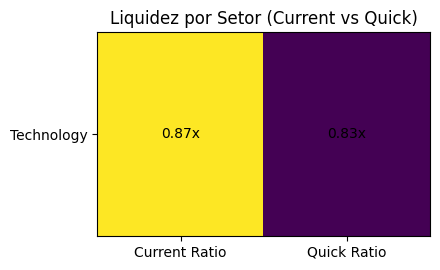

In [14]:

# ---------------------------
# 2) Heatmap: Current Ratio & Quick Ratio por setor
# ---------------------------
# For now, we have a single sector. This still renders; you can add more rows later.
heatmap_df = pd.DataFrame(
    { "Current Ratio": [current_ratio], "Quick Ratio": [quick_ratio] },
    index=[sector]
)

fig2, ax2 = plt.subplots(figsize=(4.5, 2.8))
im = ax2.imshow(heatmap_df.values, aspect="auto")

# Ticks
ax2.set_xticks(np.arange(heatmap_df.shape[1]))
ax2.set_yticks(np.arange(heatmap_df.shape[0]))
ax2.set_xticklabels(heatmap_df.columns)
ax2.set_yticklabels(heatmap_df.index)

# Annotate values
for i in range(heatmap_df.shape[0]):
    for j in range(heatmap_df.shape[1]):
        val = heatmap_df.values[i, j]
        ax2.text(j, i, f"{val:.2f}x", ha="center", va="center")

ax2.set_title("Liquidez por Setor (Current vs Quick)")
heatmap_path = fig2.tight_layout()


heatmap_path
